In [31]:
import pandas as pd
import numpy as np

# Set random seed for reproducibility
np.random.seed(42)

# Generate synthetic data
n_samples = 1000
data = {
    'timestamp': pd.date_range(start='2024-01-01', periods=n_samples, freq='h'),
    'cpu_usage': np.random.normal(50, 10, n_samples),       # CPU usage in percentage
    'memory_usage': np.random.normal(60, 15, n_samples),    # Memory usage in percentage
    'network_latency': np.random.normal(100, 20, n_samples), # Network latency in ms
    'disk_io': np.random.normal(75, 10, n_samples),         # Disk I/O in MB/s
    'error_rate': np.random.choice([0, 1], n_samples, p=[0.95, 0.05])  # 5% error rate
}

# Create DataFrame
df = pd.DataFrame(data)

# Simulate a network error by altering the dataset
df.loc[0, 'network_latency'] = 1000  # Simulating high network latency

# Display the first few rows of the dataset
print(df.head())
print(df.info())

            timestamp  cpu_usage  memory_usage  network_latency    disk_io  \
0 2024-01-01 00:00:00  54.967142     80.990332      1000.000000  55.921924   
1 2024-01-01 01:00:00  48.617357     73.869505        97.109627  66.396150   
2 2024-01-01 02:00:00  56.476885     60.894456        84.151602  70.863945   
3 2024-01-01 03:00:00  65.230299     50.295948        93.840769  93.876877   
4 2024-01-01 04:00:00  47.658466     70.473350        62.127707  80.565531   

   error_rate  
0           0  
1           0  
2           1  
3           0  
4           0  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   timestamp        1000 non-null   datetime64[ns]
 1   cpu_usage        1000 non-null   float64       
 2   memory_usage     1000 non-null   float64       
 3   network_latency  1000 non-null   float64       
 4   disk_io

In [32]:
from sklearn.ensemble import IsolationForest

# Implement anomaly detection using Isolation Forest
def detect_anomalies(data):
    model = IsolationForest(contamination=0.05, random_state=42)
    model.fit(data)
    anomalies = model.predict(data)
    return anomalies

# Detect anomalies in the dataset 
numeric_data = df.select_dtypes(include=[float, int]) # Only numeric columns 
df['anomaly'] = detect_anomalies(numeric_data)

print(df['anomaly'].value_counts()) # -1 denotes an anomaly

anomaly
 1    950
-1     50
Name: count, dtype: int64


In [33]:
from scipy.stats import zscore

# Calculate z-scores to identify anomalous values per column in anomalous rows
z_scores = numeric_data.apply(zscore)

# Function to identify anomalous columns for each row
def find_anomalous_columns(row, threshold=3):
    return [col for col in numeric_data.columns if abs(z_scores.loc[row.name, col]) > threshold]

# Apply the function to each anomalous row
df['anomalous_columns'] = df.apply(lambda row: find_anomalous_columns(row) if row['anomaly'] == -1 else [], axis=1)

# Display rows with anomalies and their anomalous columns
print(df[df['anomaly'] == -1][['timestamp', 'anomaly', 'anomalous_columns']])

              timestamp  anomaly        anomalous_columns
0   2024-01-01 00:00:00       -1        [network_latency]
37  2024-01-02 13:00:00       -1             [error_rate]
38  2024-01-02 14:00:00       -1             [error_rate]
62  2024-01-03 14:00:00       -1             [error_rate]
132 2024-01-06 12:00:00       -1             [error_rate]
179 2024-01-08 11:00:00       -1             [error_rate]
192 2024-01-09 00:00:00       -1             [error_rate]
208 2024-01-09 16:00:00       -1             [error_rate]
241 2024-01-11 01:00:00       -1             [error_rate]
245 2024-01-11 05:00:00       -1             [error_rate]
251 2024-01-11 11:00:00       -1             [error_rate]
262 2024-01-11 22:00:00       -1  [cpu_usage, error_rate]
272 2024-01-12 08:00:00       -1             [error_rate]
285 2024-01-12 21:00:00       -1             [error_rate]
315 2024-01-14 03:00:00       -1             [error_rate]
329 2024-01-14 17:00:00       -1             [error_rate]
330 2024-01-14

In [34]:
# Add this after creating the DataFrame but before training the model
df['year'] = df['timestamp'].dt.year
df['month'] = df['timestamp'].dt.month  
df['day'] = df['timestamp'].dt.day
df['hour'] = df['timestamp'].dt.hour
df['minute'] = df['timestamp'].dt.minute

# Then drop the original timestamp column
df = df.drop('timestamp', axis=1)

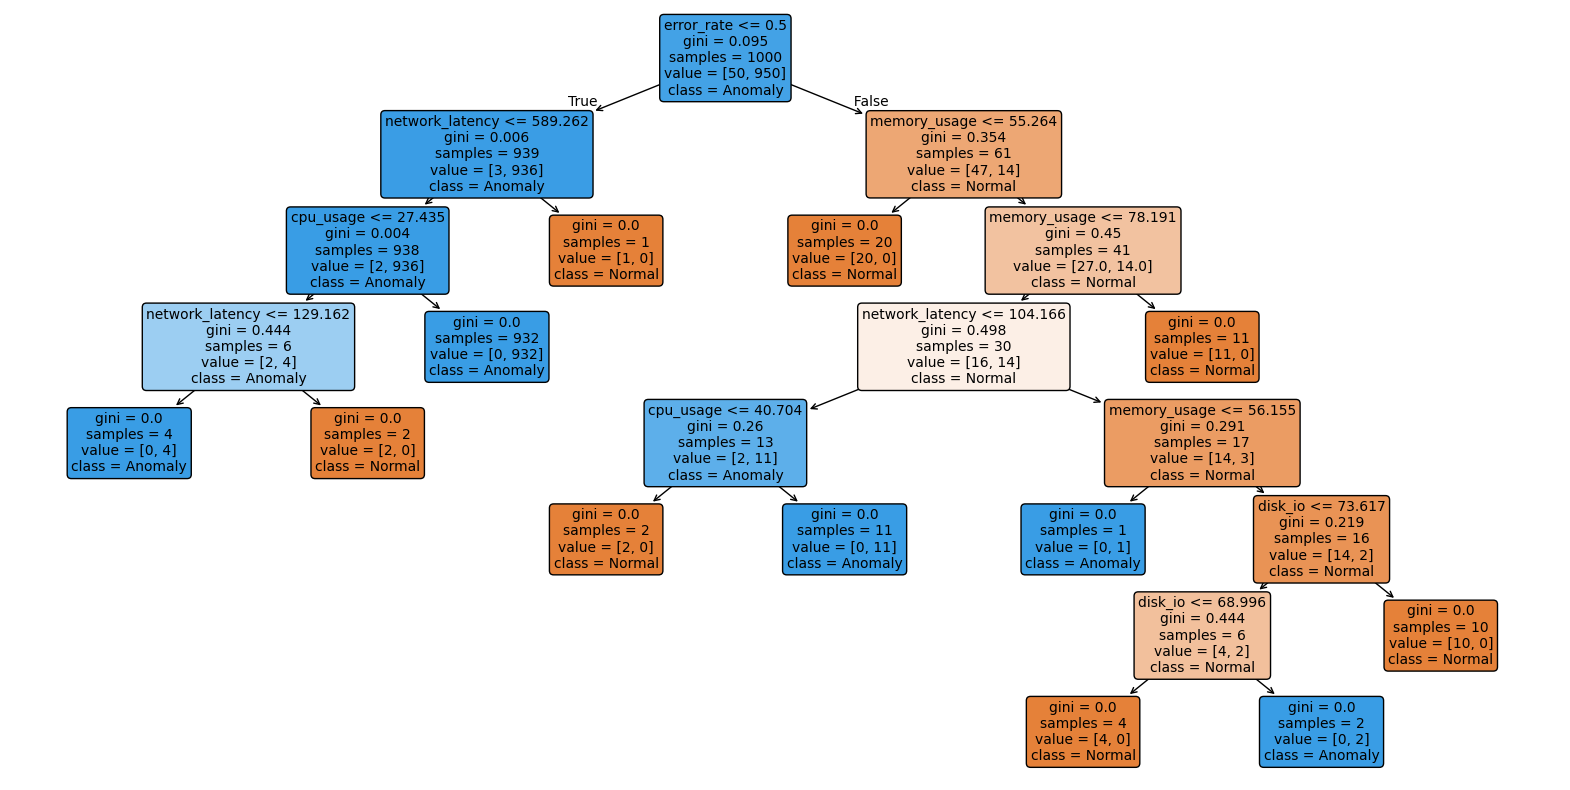

In [37]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

# Train a decision tree for root cause analysis
def root_cause_analysis(X_train, y_train, X_test):
    model = DecisionTreeClassifier()
    model.fit(X_train, y_train)


    # After training your model
    plt.figure(figsize=(20,10))
    plot_tree(model, 
            feature_names=X_train.columns.tolist(),
            class_names=['Normal', 'Anomaly'],
            filled=True, 
            rounded=True,
            fontsize=10)
    plt.show()
    predictions = model.predict(X_test)
    return predictions

# Example root cause analysis (assuming data is preprocessed)
X_train = df.drop(['anomaly', 'anomalous_columns'], axis=1)
y_train = df['anomaly']
predicted_causes = root_cause_analysis(X_train, y_train, X_train)

In [24]:
predicted_causes

array([-1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1, -1, -1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1, -1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1, -1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1, -1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1, -1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1, -1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1

In [25]:
# Example solution recommendation based on root cause
def recommend_solution(root_cause):
    solutions = {
        "network_error": "Restart the network service.",
        "database_issue": "Check the database connection and restart the service.",
        "high_cpu_usage": "Optimize running processes or allocate more resources."
    }
    return solutions.get(root_cause, "No recommendation available.")

# Recommend a solution based on a detected root cause
solution = recommend_solution("network_error")
print(f"Recommended solution: {solution}")

Recommended solution: Restart the network service.


In [28]:
df.select_dtypes(include=[float, int])

,cpu_usage,memory_usage,network_latency,disk_io,error_rate,anomaly,year,month,day,hour,minute
0,54.967142,80.990332,1000.000000,55.921924,0,-1,2024,1,1,0,0
1,48.617357,73.869505,97.109627,66.396150,0,1,2024,1,1,1,0
2,56.476885,60.894456,84.151602,70.863945,1,1,2024,1,1,2,0
3,65.230299,50.295948,93.840769,93.876877,0,1,2024,1,1,3,0
4,47.658466,70.473350,62.127707,80.565531,0,1,2024,1,1,4,0
...,...,...,...,...,...,...,...,...,...,...,...
995,47.188997,76.052254,101.549610,75.284576,0,1,2024,2,11,11,0
996,67.976865,59.602181,105.155051,54.221882,0,1,2024,2,11,12,0
997,56.408429,46.771880,75.164788,71.797022,0,1,2024,2,11,13,0
998,44.288210,57.553996,106.683528,91.433782,0,1,2024,2,11,14,0


In [29]:
predicted_causes[0]

np.int64(-1)

In [ ]:
# Run the troubleshooting agent
# Detect anomalies in the dataset 
numeric_data = df.select_dtypes(include=[float, int]) # Only numeric columns 
df['anomaly'] = detect_anomalies(numeric_data)
predicted_causes = root_cause_analysis(X_train, y_train, X_train)
solution = recommend_solution(predicted_causes[0])
print(f"Detected issue: {predicted_causes[0]}")
print(f"Recommended solution: {solution}")

Detected issue: -1
Recommended solution: No recommendation available.


In [27]:
df.loc[0]

cpu_usage                    54.967142
memory_usage                 80.990332
network_latency                 1000.0
disk_io                      55.921924
error_rate                           0
anomaly                             -1
anomalous_columns    [network_latency]
year                              2024
month                                1
day                                  1
hour                                 0
minute                               0
Name: 0, dtype: object